##Problem Statement: 

Train a model for building a Question Answering Pipeline and build a Haystack extractive QA pipeline for serving requests. Haystack QA pipeline typically consists of a Retriever and a Reader.  The pipeline receives the query and runs it through the components of the pipeline graph and the retriever connects to a datastore (like Elasticsearch or Weaviate) to fetch the relevant data.

## Specifications of the Model Used for QA objective <br>
Language model: roberta-base <br>
Language: English <br>
Downstream-task: Extractive QA <br>
Training data: SQuAD 2.0 <br>
Eval data: SQuAD 2.0 <br>

In [ ]:
! pip install datasets transformers
! apt install git-lfs

## Initialization for Training

In [ ]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer

In [ ]:
model_name = 'deepset/roberta-base-squad2'
model = AutoModelForQuestionAnswering.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

## SELQA Dataset

The SelQA dataset provides crowdsourced annotation for two selection-based question answer tasks, answer sentence selection and answer triggering. The dataset composes about 8K factoid questions for the top-10 most prevalent topics among Wikipedia articles. 

In [ ]:
from datasets import load_dataset, load_metric

datasets = load_dataset('selqa')

No config specified, defaulting to: selqa/answer_selection_analysis
Reusing dataset selqa (/root/.cache/huggingface/datasets/selqa/answer_selection_analysis/1.1.0/df32394da83caa47bbdc1df6db7d50432c2d73a25ac35c4ce95514a70c61fa1c)


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
datasets

DatasetDict({
    train: Dataset({
        features: ['section', 'question', 'article', 'is_paraphrase', 'topic', 'answers', 'candidates', 'q_types'],
        num_rows: 5529
    })
    test: Dataset({
        features: ['section', 'question', 'article', 'is_paraphrase', 'topic', 'answers', 'candidates', 'q_types'],
        num_rows: 1590
    })
    validation: Dataset({
        features: ['section', 'question', 'article', 'is_paraphrase', 'topic', 'answers', 'candidates', 'q_types'],
        num_rows: 785
    })
})

In [ ]:
datasets['train'][0]

{'answers': [4],
 'article': 'Table tennis',
 'candidates': ['The international rules specify that the game is played with a light 2.7 gram, 40\xa0mm diameter ball.',
  'The rules say that the ball shall bounce up 24–26\xa0cm when dropped from a height of 30.5\xa0cm onto a standard steel block thereby having a coefficient of restitution of 0.89 to 0.92.',
  'The 40\xa0mm ball was introduced after the 2000 Olympic Games.',
  'However, this created some controversy as the Chinese National Team argued that this was merely to give non-Chinese players a better chance of winning since the new type of balls has a slower speed, while at that time most Chinese players were playing with fast attack and smashes.',
  'A 40\xa0mm table tennis ball is slower and spins less than the original 38\xa0mm (1.5\xa0inch) one.',
  'The ball is made of a high-bouncing air-filled celluloid or similar plastics material, colored white or orange, with a matte finish.',
  'The choice of ball color is made accordin

Displaying few records from SELQA

In [ ]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

In [ ]:
show_random_elements(datasets["train"])

##WandB

We Coupled Hugging face model training with Weights & Biases. With this we are able to quickly train and monitor models for full traceability and reproducibility without any extra line of code

W&B integration with 🤗 Hugging Face can automatically:
* log your configuration parameters
* log your losses and metrics
* log gradients and parameter distributions
* log your model
* keep track of your code
* log your system metrics (GPU, CPU, memory, temperature, etc)

In [ ]:
! pip install wandb

     |████████████████████████████████| 1.7 MB 12.7 MB/s 
     |████████████████████████████████| 180 kB 78.9 MB/s 
     |████████████████████████████████| 140 kB 70.6 MB/s 
     |████████████████████████████████| 97 kB 8.1 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=96d186e7d005cb7d6826c9c1dc20f2c3003dc3c42bc2499c2fe1fe5d89bc9ddd
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=5354fe700f9062ab0aca13138c2918c5dab5d332456582fd4b0ff290b34de01e
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [ ]:
! wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## tokenization and input preprocessing

In [ ]:
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

In [ ]:
tokenizer("What is your name?", "My name is Sylvain.")

{'input_ids': [0, 2264, 16, 110, 766, 116, 2, 2, 2387, 766, 16, 28856, 1851, 4, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
max_length = 386 # The maximum length of a feature (question and context)
doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.

In [ ]:
join_sentences = lambda lst: ''.join(lst)

In [ ]:
for idx, example in enumerate(datasets["train"]):
    example['context'] = join_sentences(example['candidates'])
    if len(tokenizer(example["question"], example["context"])["input_ids"]) > max_length:
        break
example = datasets["train"][idx]

In [ ]:
example['context'] = join_sentences(example['candidates'])
len(tokenizer(example["question"], example["context"])["input_ids"])

486

In [ ]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    stride=doc_stride
)

In [ ]:
[len(x) for x in tokenized_example["input_ids"]]

[386, 240]

In [ ]:
for x in tokenized_example["input_ids"][:2]:
    print(tokenizer.decode(x))

<s>What does Pink wear in the video?</s></s>The music video for "Blow Me (One Last Kiss)" premiered on July 26, 2012 at 7:50pm EDT on MTV and VEVO and was directed by Pink's longtime collaborator Dave Meyers, who directed the videos for almost all of her lead singles and many of her hits.The official colored version of the video was leaked online on August 31, and was officially posted on VEVO on September 5, 2012.The video is entirely in black and white, with splashes of color, features opening titles in French.The video begins with Pink having a picnic with her love interest (Sebastian de la Forza).The two lean in for a kiss, which is interrupted by him taking a phone call.Pink splashes him with red wine, and walks away through the trees.She meets another man on his motorbike (Alexander Ercheverria) and goes home with him.He draws a portrait of her.Pink watches through the window as many female guests arrive for a party the man has organised.During the party, she dances with one of t

In [ ]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    stride=doc_stride
)
print(tokenized_example["offset_mapping"][0][:100])

[(0, 0), (0, 4), (5, 9), (10, 14), (15, 19), (20, 22), (23, 26), (27, 32), (32, 33), (0, 0), (0, 0), (0, 3), (4, 9), (10, 15), (16, 19), (20, 21), (21, 23), (23, 25), (26, 28), (29, 30), (30, 33), (34, 38), (39, 43), (43, 45), (46, 55), (56, 58), (59, 63), (64, 66), (66, 67), (68, 72), (73, 75), (76, 77), (77, 78), (78, 80), (80, 82), (83, 86), (87, 89), (90, 93), (94, 97), (98, 99), (99, 101), (101, 102), (103, 106), (107, 110), (111, 119), (120, 122), (123, 127), (127, 129), (130, 138), (139, 151), (152, 156), (157, 159), (159, 163), (163, 164), (165, 168), (169, 177), (178, 181), (182, 188), (189, 192), (193, 199), (200, 203), (204, 206), (207, 210), (211, 215), (216, 223), (224, 227), (228, 232), (233, 235), (236, 239), (240, 244), (244, 245), (245, 248), (249, 257), (258, 265), (266, 273), (274, 276), (277, 280), (281, 286), (287, 290), (291, 297), (298, 304), (305, 307), (308, 314), (315, 317), (317, 318), (319, 322), (323, 326), (327, 337), (338, 344), (345, 347), (348, 349), (3

In [ ]:
first_token_id = tokenized_example["input_ids"][0][1]
offsets = tokenized_example["offset_mapping"][0][1]
print(tokenizer.convert_ids_to_tokens([first_token_id])[0], example["question"][offsets[0]:offsets[1]])

What What


In [ ]:
sequence_ids = tokenized_example.sequence_ids()
print(sequence_ids)

[None, 0, 0, 0, 0, 0, 0, 0, 0, None, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
idx = example['answers'][0]
start_char = len(''.join(example['candidates'][:idx]))
end_char = start_char + len(''.join(example['candidates'][idx]))

In [ ]:
start_char = len(''.join(example['candidates'][:idx]))
end_char = start_char + len(''.join(example['candidates'][idx]))

# Start token index of the current span in the text.
token_start_index = 0
while sequence_ids[token_start_index] != 1:
    token_start_index += 1

# End token index of the current span in the text.
token_end_index = len(tokenized_example["input_ids"][0]) - 1
while sequence_ids[token_end_index] != 1:
    token_end_index -= 1

# Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
offsets = tokenized_example["offset_mapping"][0]
if (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
    # Move the token_start_index and token_end_index to the two ends of the answer.
    # Note: we could go after the last offset if the answer is the last word (edge case).
    while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
        token_start_index += 1
    start_position = token_start_index - 1
    while offsets[token_end_index][1] >= end_char:
        token_end_index -= 1
    end_position = token_end_index + 1
    print(start_position, end_position)
else:
    print("The answer is not in this feature.")

244 262


In [ ]:
print(tokenizer.decode(tokenized_example["input_ids"][0][start_position: end_position+1]))
print(example['candidates'][idx])

Pink wears a black suit with her hair pushed back and dances with the woman (Mosh).
Pink wears a black suit with her hair pushed back and dances with the woman (Mosh).


In [ ]:
pad_on_right = tokenizer.padding_side == "right"

## Input text preproces function for training

In [ ]:
def prepare_train_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]
    context = [join_sentences(lst) for lst in examples["candidates"]]
    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question"] if pad_on_right else context,
        context if pad_on_right else examples["question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    offset_mapping = tokenized_examples.pop("offset_mapping")

    # Let's label those examples!
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for idx, offsets in enumerate(offset_mapping):
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][idx]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(idx)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[idx]
        # If no answers are given, set the cls_index as answer.
        if len(examples["answers"][sample_index]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
          # Start/end character index of the answer in the text.
          i = examples["answers"][sample_index][0]
          start_char = len(''.join(examples['candidates'][sample_index][:i]))
          end_char = start_char + len(''.join(examples['candidates'][sample_index][i]))

          # Start token index of the current span in the text.
          token_start_index = 0
          while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
              token_start_index += 1

          # End token index of the current span in the text.
          token_end_index = len(input_ids) - 1
          while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
              token_end_index -= 1

          # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
          if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
              tokenized_examples["start_positions"].append(cls_index)
              tokenized_examples["end_positions"].append(cls_index)
          else:
              # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
              # Note: we could go after the last offset if the answer is the last word (edge case).
              while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                  token_start_index += 1
              tokenized_examples["start_positions"].append(token_start_index - 1)
              while offsets[token_end_index][1] >= end_char:
                  token_end_index -= 1
              tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

In [ ]:
features = prepare_train_features(datasets['train'][:5])

## Tokenizing the dataset

In [ ]:
tokenized_datasets = datasets.map(prepare_train_features, batched=True, remove_columns=datasets["train"].column_names)

Loading cached processed dataset at /root/.cache/huggingface/datasets/selqa/answer_selection_analysis/1.1.0/df32394da83caa47bbdc1df6db7d50432c2d73a25ac35c4ce95514a70c61fa1c/cache-28e0ed6454cc51ef.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/selqa/answer_selection_analysis/1.1.0/df32394da83caa47bbdc1df6db7d50432c2d73a25ac35c4ce95514a70c61fa1c/cache-a00712e4342d90fa.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/selqa/answer_selection_analysis/1.1.0/df32394da83caa47bbdc1df6db7d50432c2d73a25ac35c4ce95514a70c61fa1c/cache-b628047d7725b223.arrow


## Training Parameters

Due to memory constraint, fell back to 24 batch size from 32 batch size

In [ ]:
batch_size = 24
epochs = 10

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

ERROR:root:HfApi.login: This method is deprecated in favor of `set_access_token`.


Login successful
Your token has been saved to /root/.huggingface/token


In [ ]:
!git config --global credential.helper store

## Setting up the training arguments with W&B for reporting

In [ ]:
from transformers import TrainingArguments, Trainer



args = TrainingArguments(
    f"{model_name}-finetuned-selqa",
    report_to = 'wandb',
    run_name = 'custom_training_latest',
    evaluation_strategy = "epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epochs,
    weight_decay=0.01,
    push_to_hub=True,
)

In [ ]:
from transformers import default_data_collator

data_collator = default_data_collator

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
)

/content/deepset/roberta-base-squad2-finetuned-selqa is already a clone of https://huggingface.co/Teepika/roberta-base-squad2-finetuned-selqa. Make sure you pull the latest changes with `repo.git_pull()`.


## Training 

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 8202
  Num Epochs = 10
  Instantaneous batch size per device = 24
  Total train batch size (w. parallel, distributed & accumulation) = 24
  Gradient Accumulation steps = 1
  Total optimization steps = 3420
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Currently logged in as: teepika_rm (use `wandb login --relogin` to force relogin)


Epoch,Training Loss,Validation Loss
1,No log,0.353826
2,0.565200,0.360392
3,0.209900,0.339991
4,0.209900,0.459076
5,0.100200,0.503750
6,0.056700,0.430538
7,0.056700,0.493669
8,0.034600,0.519275
9,0.018600,0.489277


***** Running Evaluation *****
  Num examples = 1172
  Batch size = 24
Saving model checkpoint to deepset/roberta-base-squad2-finetuned-selqa/checkpoint-500
Configuration saved in deepset/roberta-base-squad2-finetuned-selqa/checkpoint-500/config.json
Model weights saved in deepset/roberta-base-squad2-finetuned-selqa/checkpoint-500/pytorch_model.bin
tokenizer config file saved in deepset/roberta-base-squad2-finetuned-selqa/checkpoint-500/tokenizer_config.json
Special tokens file saved in deepset/roberta-base-squad2-finetuned-selqa/checkpoint-500/special_tokens_map.json
tokenizer config file saved in deepset/roberta-base-squad2-finetuned-selqa/tokenizer_config.json
Special tokens file saved in deepset/roberta-base-squad2-finetuned-selqa/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1172
  Batch size = 24
Saving model checkpoint to deepset/roberta-base-squad2-finetuned-selqa/checkpoint-1000
Configuration saved in deepset/roberta-base-squad2-finetuned-selqa/checkp

Epoch,Training Loss,Validation Loss
1,No log,0.353826
2,0.565200,0.360392
3,0.209900,0.339991
4,0.209900,0.459076
5,0.100200,0.503750
6,0.056700,0.430538
7,0.056700,0.493669
8,0.034600,0.519275
9,0.018600,0.489277
10,0.018600,0.523494


***** Running Evaluation *****
  Num examples = 1172
  Batch size = 24


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=3420, training_loss=0.1454621606402927, metrics={'train_runtime': 1970.0996, 'train_samples_per_second': 41.632, 'train_steps_per_second': 1.736, 'total_flos': 1.615738702181616e+16, 'train_loss': 0.1454621606402927, 'epoch': 10.0})

Eval loss and Summary extracted from W&B dashboard for the model training

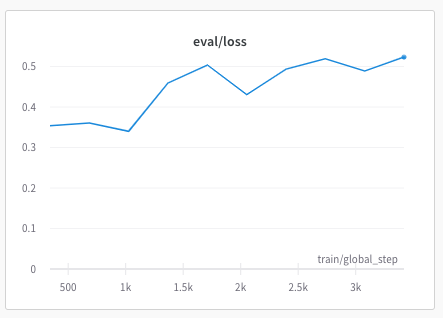

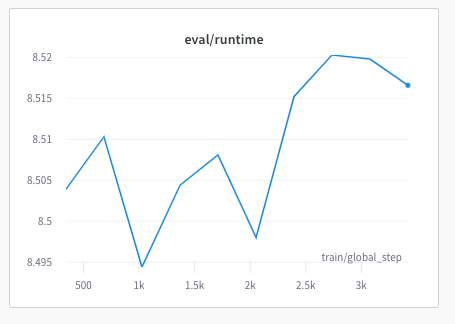

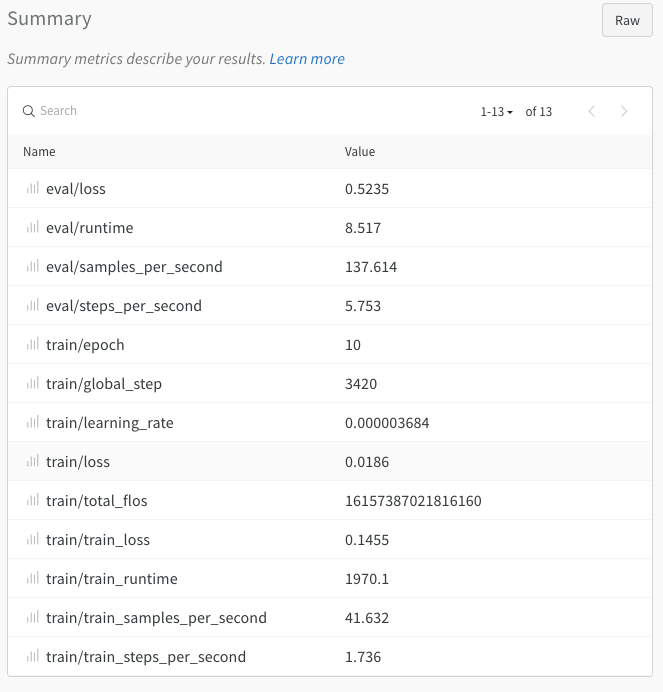

In [ ]:
# trainer.train()

***** Running training *****
  Num examples = 8202
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 771


Epoch,Training Loss,Validation Loss
1,No log,0.377454
2,0.521400,0.353950
3,0.521400,0.342575


***** Running Evaluation *****
  Num examples = 1172
  Batch size = 32
Saving model checkpoint to deepset/roberta-base-squad2-finetuned-selqa/checkpoint-500
Configuration saved in deepset/roberta-base-squad2-finetuned-selqa/checkpoint-500/config.json
Model weights saved in deepset/roberta-base-squad2-finetuned-selqa/checkpoint-500/pytorch_model.bin
tokenizer config file saved in deepset/roberta-base-squad2-finetuned-selqa/checkpoint-500/tokenizer_config.json
Special tokens file saved in deepset/roberta-base-squad2-finetuned-selqa/checkpoint-500/special_tokens_map.json
tokenizer config file saved in deepset/roberta-base-squad2-finetuned-selqa/tokenizer_config.json
Special tokens file saved in deepset/roberta-base-squad2-finetuned-selqa/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 1172
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1172
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=771, training_loss=0.4039787114362309, metrics={'train_runtime': 9390.9729, 'train_samples_per_second': 2.62, 'train_steps_per_second': 0.082, 'total_flos': 4847216106544848.0, 'train_loss': 0.4039787114362309, 'epoch': 3.0})

In [ ]:
# trainer.save_model("roberta-base-squad2-finetuned-selqa-3")

Saving model checkpoint to roberta-base-squad2-finetuned-selqa-3
Configuration saved in roberta-base-squad2-finetuned-selqa-3/config.json
Model weights saved in roberta-base-squad2-finetuned-selqa-3/pytorch_model.bin
tokenizer config file saved in roberta-base-squad2-finetuned-selqa-3/tokenizer_config.json
Special tokens file saved in roberta-base-squad2-finetuned-selqa-3/special_tokens_map.json


In [ ]:
import os
from google.colab import drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:

DIRECTORY = '/content/drive/Shareddrives/CMPE297' 

if os.getcwd() != DIRECTORY:
  os.chdir(DIRECTORY)

In [ ]:
! ls -lrt

total 16
drwxr-xr-x 1 root root 4096 Dec  3 14:33 sample_data
drwxr-xr-x 3 root root 4096 Dec  8 20:23 deepset
drwxr-xr-x 6 root root 4096 Dec  8 21:01 wandb
drwx------ 6 root root 4096 Dec  8 21:37 drive


In [ ]:
model = AutoModelForQuestionAnswering.from_pretrained('./deepset/roberta-base-squad2-finetuned-selqa')

loading configuration file ./deepset/roberta-base-squad2-finetuned-selqa/config.json
Model config RobertaConfig {
  "_name_or_path": "deepset/roberta-base-squad2",
  "architectures": [
    "RobertaForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "language": "english",
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "name": "Roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.12.5",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file ./deepset/roberta-base-squad2-finetuned-selqa/pytorch_model.bin
All model checkpoint weig

In [ ]:
!huggingface-cli login


        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/token.
        (Deprecated, will be removed in v0.3.0) To login with username and password instead, interrupt with Ctrl+C.
        
Token: 
Login successful
Your token has been saved to /root/.huggingface/token


In [ ]:
!apt install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.3.4-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [ ]:
!huggingface-cli repo create roberta-base-squad2-finetuned-selqa

git version 2.17.1
Error: unknown flag: --version

Sorry, no usage text found for "git-lfs"

You are about to create Teepika/roberta-base-squad2-finetuned-selqa
Proceed? [Y/n] Y
409 Client Error: Conflict for url: https://huggingface.co/api/repos/create - You already created this model repo
{"error":"You already created this model repo","url":"https://huggingface.co/Teepika/roberta-base-squad2-finetuned-selqa"}


In [ ]:
!git lfs install

Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.


In [ ]:
!git clone https://huggingface.co/Teepika/roberta-base-squad2-finetuned-selqa

Cloning into 'roberta-base-squad2-finetuned-selqa'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (3/3), done.


In [ ]:
!git clone https://huggingface.co/duncaninganji/roberta-base-squad2-finetuned-selqa-3

Cloning into 'roberta-base-squad2-finetuned-selqa-3'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0)
Unpacking objects: 100% (3/3), done.


In [ ]:
!cd roberta-base-squad2-finetuned-selqa && ls

In [ ]:
!cd roberta-base-squad2-finetuned-selqa
!echo "modelv1" >> README.md
!git add . && git commit -m "modelv1 from $USER"

fatal: not a git repository (or any of the parent directories): .git


## Saving the model in huggingface hub

In [ ]:
model.push_to_hub('roberta-base-squad2-finetuned-selqa')

Configuration saved in roberta-base-squad2-finetuned-selqa/config.json
Model weights saved in roberta-base-squad2-finetuned-selqa/pytorch_model.bin


Upload file pytorch_model.bin:   0%|          | 3.37k/473M [00:00<?, ?B/s]

To https://huggingface.co/Teepika/roberta-base-squad2-finetuned-selqa
   bb895b1..6182f6a  main -> main

   bb895b1..6182f6a  main -> main



'https://huggingface.co/Teepika/roberta-base-squad2-finetuned-selqa/commit/6182f6a901980ea056ac4394a819ace777759d21'

In [ ]:
tokenizer.push_to_hub('roberta-base-squad2-finetuned-selqa')

tokenizer config file saved in roberta-base-squad2-finetuned-selqa/tokenizer_config.json
Special tokens file saved in roberta-base-squad2-finetuned-selqa/special_tokens_map.json
To https://huggingface.co/Teepika/roberta-base-squad2-finetuned-selqa
   6182f6a..3abcf22  main -> main

   6182f6a..3abcf22  main -> main



'https://huggingface.co/Teepika/roberta-base-squad2-finetuned-selqa/commit/3abcf22e3c2d007e982e1b121e23d044cd01fb5e'

In [ ]:
model_name = 'Teepika/roberta-base-squad2-finetuned-selqa'
model = AutoModelForQuestionAnswering.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

## Extractive QA pipeline

In [ ]:
import os
from google.colab import drive

drive.mount('/content/drive')

DIRECTORY = '/content/drive/Shareddrives/CMPE297' 

if os.getcwd() != DIRECTORY:
  os.chdir(DIRECTORY)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers

In [ ]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer

In [ ]:
!nvidia-smi

Thu Dec  9 19:20:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install grpcio-tools==1.34.1
!pip install git+https://github.com/deepset-ai/haystack.git

  Cloning https://github.com/deepset-ai/haystack.git to /tmp/pip-req-build-nsmhgwcz
  Running command git clone -q https://github.com/deepset-ai/haystack.git /tmp/pip-req-build-nsmhgwcz


Haystack DocumentStore Type : InMemoryDocumentStore <br>
Reader : FARMReader <br>
Retriever : TfidfRetriever <br>
Model Used for reader : deepset/roberta-base-squad2 <br>

Haystack DocumentStore Type : InMemoryDocumentStore <br>
Reader : FARMReader <br>
Retriever : TfidfRetriever <br>
Model Used for reader : roberta-base-squad2-finetuned-selqa (Our finetuned model)<br>

In [ ]:
from haystack.utils import clean_wiki_text, convert_files_to_dicts, fetch_archive_from_http, print_answers
from haystack.nodes import FARMReader, TransformersReader

/usr/local/lib/python3.7/dist-packages/ray/autoscaler/_private/cli_logger.py:61: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  "update your install command.", FutureWarning)


In [ ]:
# In-Memory Document Store
from haystack.document_stores import InMemoryDocumentStore
document_store = InMemoryDocumentStore()

In [ ]:
# Let's first fetch some documents that we want to query
# Here: 517 Wikipedia articles for Game of Thrones
doc_dir = "data/article_txt_got"
s3_url = "https://s3.eu-central-1.amazonaws.com/deepset.ai-farm-qa/datasets/documents/wiki_gameofthrones_txt.zip"
fetch_archive_from_http(url=s3_url, output_dir=doc_dir)

# Convert files to dicts
# You can optionally supply a cleaning function that is applied to each doc (e.g. to remove footers)
# It must take a str as input, and return a str.
dicts = convert_files_to_dicts(dir_path=doc_dir, clean_func=clean_wiki_text, split_paragraphs=True)

# We now have a list of dictionaries that we can write to our document store.
# If your texts come from a different source (e.g. a DB), you can of course skip convert_files_to_dicts() and create the dictionaries yourself.
# The default format here is:
# {
#    'text': "<DOCUMENT_TEXT_HERE>",
#    'meta': {'name': "<DOCUMENT_NAME_HERE>", ...}
#}
# (Optionally: you can also add more key-value-pairs here, that will be indexed as fields in Elasticsearch and
# can be accessed later for filtering or shown in the responses of the Pipeline)

# Let's have a look at the first 3 entries:
print(dicts[:3])

# Now, let's write the dicts containing documents to our DB.
document_store.write_documents(dicts)

INFO - haystack.utils.import_utils -  Found data stored in `data/article_txt_got`. Delete this first if you really want to fetch new data.
INFO - haystack.utils.preprocessing -  Converting data/article_txt_got/299_Rani_Mahal__TV_series_.txt
INFO - haystack.utils.preprocessing -  Converting data/article_txt_got/133_Game_of_Thrones__Season_5__soundtrack_.txt
INFO - haystack.utils.preprocessing -  Converting data/article_txt_got/135_Game_of_Thrones__Season_7__soundtrack_.txt
INFO - haystack.utils.preprocessing -  Converting data/article_txt_got/26_Game_of_Thrones__Season_3__soundtrack_.txt
INFO - haystack.utils.preprocessing -  Converting data/article_txt_got/399_For_the_Throne__Music_Inspired_by_the_HBO_Series_Game_of_Thrones.txt
INFO - haystack.utils.preprocessing -  Converting data/article_txt_got/365_A_Song_of_Ice_and_Fire_Roleplaying.txt
INFO - haystack.utils.preprocessing -  Converting data/article_txt_got/52_Catch_the_Throne.txt
INFO - haystack.utils.preprocessing -  Converting dat

[{'content': "'''''Rani Mahal''''' is an upcoming Indian television series, which will air on Sony Entertainment Television (India) and Sony Entertainment Television Asia. Many news sources claimed that this show is an Indian adaptation of American fantasy drama series ''Game of Thrones'' which based on best-selling novel ''A Song of Ice and Fire'', which has been denied by Sony Entertainment Television (India) and Lost Boy Productions.", 'meta': {'name': '299_Rani_Mahal__TV_series_.txt'}}, {'content': '\n==External links==', 'meta': {'name': '299_Rani_Mahal__TV_series_.txt'}}, {'content': "The soundtrack album of the fifth season of HBO series ''Game of Thrones'', titled '''''Game of Thrones: Season 5''''', was released digitally on June 9, 2015, and on CD on July 17, 2015. The album was composed by Ramin Djawadi.", 'meta': {'name': '133_Game_of_Thrones__Season_5__soundtrack_.txt'}}]


INFO - haystack.document_stores.base -  Duplicate Documents: Document with id '9e9a3181b6bc168b4a25429b641e8c86' already exists in index 'document'
INFO - haystack.document_stores.base -  Duplicate Documents: Document with id '9e9a3181b6bc168b4a25429b641e8c86' already exists in index 'document'
INFO - haystack.document_stores.base -  Duplicate Documents: Document with id '9e9a3181b6bc168b4a25429b641e8c86' already exists in index 'document'
INFO - haystack.document_stores.base -  Duplicate Documents: Document with id '1906b2acc6c764b69e619e5eb2fa646f' already exists in index 'document'
INFO - haystack.document_stores.base -  Duplicate Documents: Document with id '9e9a3181b6bc168b4a25429b641e8c86' already exists in index 'document'
INFO - haystack.document_stores.base -  Duplicate Documents: Document with id '7ed12f389f7f085bb30c7d00abd26f81' already exists in index 'document'
INFO - haystack.document_stores.base -  Duplicate Documents: Document with id '994b9df41876668d9a5cae9510915a24'

In [ ]:
from haystack.nodes import TfidfRetriever
retriever = TfidfRetriever(document_store=document_store)

INFO - haystack.nodes.retriever.sparse -  Found 2357 candidate paragraphs from 2357 docs in DB


In [ ]:
reader = FARMReader(model_name_or_path="deepset/roberta-base-squad2", use_gpu=True)
custom_reader = FARMReader(model_name_or_path="Teepika/roberta-base-squad2-finetuned-selqa", use_gpu=True)

INFO - haystack.modeling.utils -  Using devices: CUDA
INFO - haystack.modeling.utils -  Number of GPUs: 1
INFO - haystack.modeling.model.language_model -  LOADING MODEL
INFO - haystack.modeling.model.language_model -  =============
INFO - haystack.modeling.model.language_model -  Could not find deepset/roberta-base-squad2 locally.
INFO - haystack.modeling.model.language_model -  Looking on Transformers Model Hub (in local cache and online)...
INFO - haystack.modeling.model.language_model -  Loaded deepset/roberta-base-squad2
INFO - haystack.modeling.logger -  ML Logging is turned off. No parameters, metrics or artifacts will be logged to MLFlow.
INFO - haystack.modeling.utils -  Using devices: CUDA
INFO - haystack.modeling.utils -  Number of GPUs: 1
INFO - haystack.modeling.infer -  Got ya 2 parallel workers to do inference ...
INFO - haystack.modeling.infer -   0    0 
INFO - haystack.modeling.infer -  /w\  /w\
INFO - haystack.modeling.infer -  /'\  / \
INFO - haystack.modeling.utils 

Downloading:   0%|          | 0.00/795 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/496M [00:00<?, ?B/s]

INFO - haystack.modeling.model.language_model -  Loaded Teepika/roberta-base-squad2-finetuned-selqa


Downloading:   0%|          | 0.00/798k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/772 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

INFO - haystack.modeling.logger -  ML Logging is turned off. No parameters, metrics or artifacts will be logged to MLFlow.
INFO - haystack.modeling.utils -  Using devices: CUDA
INFO - haystack.modeling.utils -  Number of GPUs: 1
INFO - haystack.modeling.infer -  Got ya 2 parallel workers to do inference ...
INFO - haystack.modeling.infer -   0    0 
INFO - haystack.modeling.infer -  /w\  /w\
INFO - haystack.modeling.infer -  /'\  / \


In [ ]:
from haystack.pipelines import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(reader, retriever)
custom_pipe = ExtractiveQAPipeline(custom_reader, retriever)

In [ ]:
prediction = pipe.run(
    query="Who is the father of Arya Stark?", params={"Retriever": {"top_k": 10}, "Reader": {"top_k": 5}}
)
custom_prediction = custom_pipe.run(
    query="Who is the father of Arya Stark?", params={"Retriever": {"top_k": 10}, "Reader": {"top_k": 5}}
)

Inferencing Samples:   0%|          | 0/1 [00:00<?, ? Batches/s]/usr/local/lib/python3.7/dist-packages/haystack/modeling/model/prediction_head.py:462: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  start_indices = flat_sorted_indices // max_seq_len
Inferencing Samples:   0%|          | 0/1 [00:00<?, ? Batches/s]/usr/local/lib/python3.7/dist-packages/haystack/modeling/model/prediction_head.py:462: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.d

In [ ]:
# Now you can either print the object directly...
from pprint import pprint

print("DISTILLBERT")
pprint(prediction)
print("ROBERTA-SELQA")
pprint(custom_prediction)

DISTILLBERT
{'answers': [<Answer {'answer': 'Eddard', 'type': 'extractive', 'score': 0.9919579923152924, 'context': "s Nymeria after a legendary warrior queen. She travels with her father, Eddard, to King's Landing when he is made Hand of the King. Before she leaves,", 'offsets_in_document': [{'start': 147, 'end': 153}], 'offsets_in_context': [{'start': 72, 'end': 78}], 'document_id': 'ba2a8e87ddd95e380bec55983ee7d55f', 'meta': {'name': '43_Arya_Stark.txt'}}>,
             <Answer {'answer': 'Ned', 'type': 'extractive', 'score': 0.9767242670059204, 'context': "\n====Season 1====\nArya accompanies her father Ned and her sister Sansa to King's Landing. Before their departure, Arya's half-brother Jon Snow gifts A", 'offsets_in_document': [{'start': 46, 'end': 49}], 'offsets_in_context': [{'start': 46, 'end': 49}], 'document_id': '180c2a6b36369712b361a80842e79356', 'meta': {'name': '43_Arya_Stark.txt'}}>,
             <Answer {'answer': 'Robert Baratheon', 'type': 'extractive', 'score': 0.

In [ ]:
print("DISTILLBERT")
print_answers(prediction, details="minimum")
print("ROBERTA-SELQA")
print_answers(custom_prediction, details="minimum")

DISTILLBERT

Query: Who is the father of Arya Stark?
Answers:
[   {   'answer': 'Eddard',
        'context': 's Nymeria after a legendary warrior queen. She travels '
                   "with her father, Eddard, to King's Landing when he is made "
                   'Hand of the King. Before she leaves,'},
    {   'answer': 'Ned',
        'context': '\n'
                   '====Season 1====\n'
                   'Arya accompanies her father Ned and her sister Sansa to '
                   "King's Landing. Before their departure, Arya's "
                   'half-brother Jon Snow gifts A'},
    {   'answer': 'Robert Baratheon',
        'context': 'hen Gendry gives it to Arya, he tells her he is the '
                   'bastard son of Robert Baratheon. Aware of their chances of '
                   'dying in the upcoming battle and Arya w'},
    {   'answer': 'Eddard and Catelyn Stark',
        'context': 'tark ===\n'
                   'Arya Stark is the third child and younger daughte